In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import Xception

train_path = '/content/drive/MyDrive/Projeto Final/kerasDataset/Dataset_crop/train'

# set batch size

BATCH_SIZE = 64

  # Por exemplo, você pode usar 20% dos dados para validação
# normalization + data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.4,
    rotation_range = 15,
    vertical_flip=True,
    validation_split=0.15
)

# normalization
val_datagen = ImageDataGenerator(rescale=1./255)

# Defina um caminho para seus dados de treinamento

# Divida os dados de treinamento em treinamento e validação  # Por exemplo, você pode usar 20% dos dados para validação
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,  # Embaralhar os dados de treinamento
    subset='training',  # Especifica o conjunto de treinamento
    seed=42,# Pode especificar uma semente para reprodução
)

val_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,  # Não embaralhar os dados de validação
    subset='validation',  # Especifica o conjunto de validação
    seed=42  # Use a mesma semente para garantir a consistência
)

# Defina a função de extração de recursos
def feature_extractor(inputs):
    # Use EfficientNetB0 em vez de Xception
    base_model = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    # Congele as camadas para que não sejam treinadas novamente
    for layer in base_model.layers:
        layer.trainable = True

    # Passe as entradas pelo modelo EfficientNet
    feature_extractor_model = base_model(inputs)
    return feature_extractor_model


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)  # Aumentado o dropout
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Mais unidades
    x = tf.keras.layers.Dropout(0.3)(x)  # Mais dropout
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Mais unidades
    x = tf.keras.layers.Dropout(0.3)(x)  # Mais dropout
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Mais unidades
    x = tf.keras.layers.Dropout(0.3)(x)  # Mais dropout
    predictions = tf.keras.layers.Dense(1, activation='sigmoid', name='classification')(x)
    return predictions



# final model

def final_model(inputs):

    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


# define and compile model
# define an optimizer

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  lr = 2e-5

  optimizer = Adam(learning_rate=lr)

  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()


# model training
num_epochs = 30
history = model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=val_data,
    batch_size = BATCH_SIZE
)

ModuleNotFoundError: No module named 'cv2'

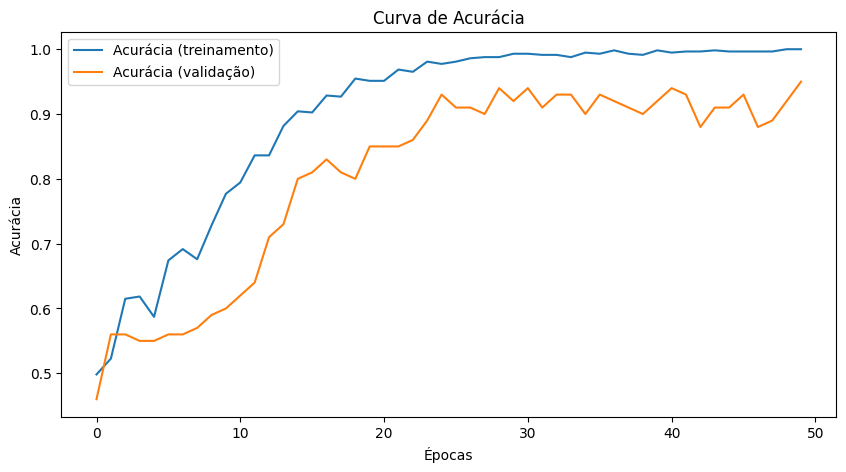

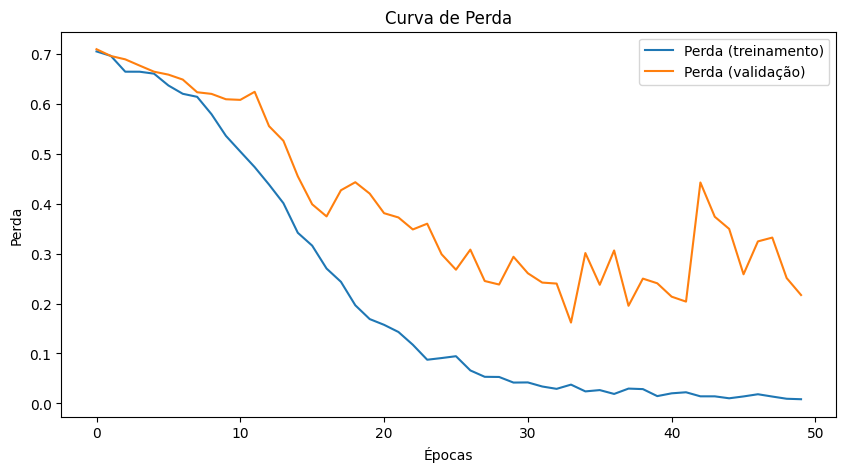

In [ ]:
# Plotar a curva de acurácia
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Acurácia (treinamento)')
plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Curva de Acurácia')
plt.show()

# Plotar a curva de perda (loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perda (treinamento)')
plt.plot(history.history['val_loss'], label='Perda (validação)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Curva de Perda')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 1s 1s/step


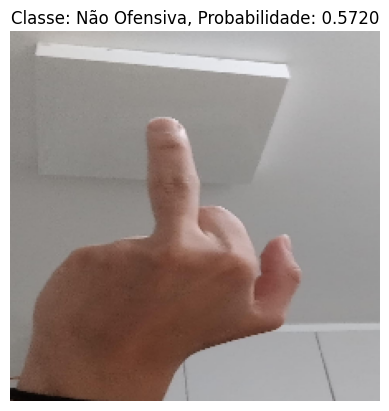

1/1 [==============================] - 0s 41ms/step


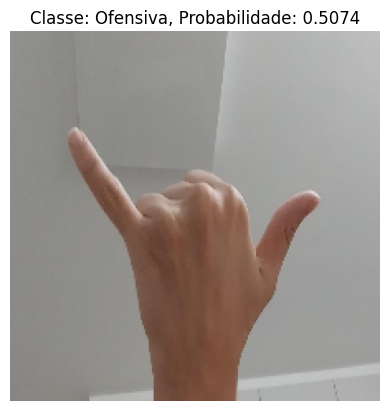

1/1 [==============================] - 0s 23ms/step


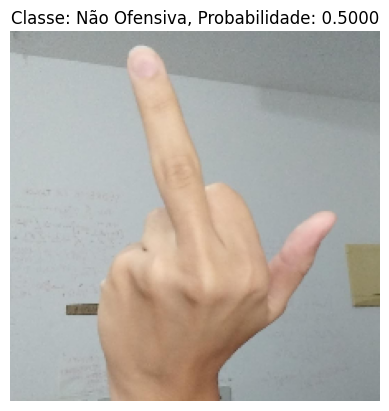

1/1 [==============================] - 0s 25ms/step


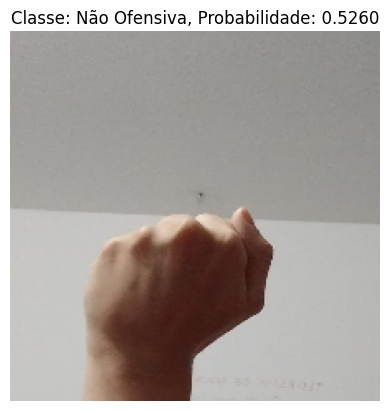

1/1 [==============================] - 0s 23ms/step


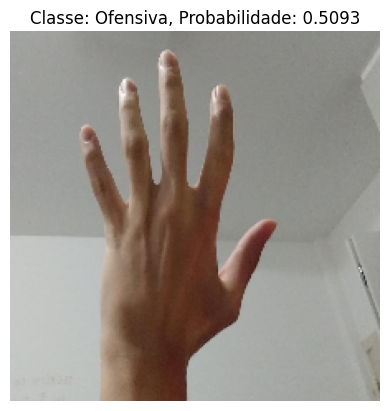

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Montar o Google Drive, se ainda não estiver montado
from google.colab import drive
drive.mount('/content/drive')

# Carregar o modelo treinado
model = define_compile_model()  # Use a função que você definiu para criar o modelo

def plot_image_with_predictions(image_path):
    # Carregar a imagem de teste
    test_image = load_img(image_path, target_size=(224, 224))
    test_image_array = img_to_array(test_image)
    test_image_array = np.expand_dims(test_image_array, axis=0)  # Adicione uma dimensão para criar um lote de tamanho 1
    test_image_array = test_image_array / 255.0  # Normalizar a imagem

    # Usar o modelo para fazer previsões
    predictions = model.predict(test_image_array)

    # O resultado conterá as probabilidades para cada classe (ofensiva e não ofensiva)
    # A primeira classe é "não ofensiva" e a segunda classe é "ofensiva"
    probability_offensive = predictions[0][0]
    probability_non_offensive = 1 - probability_offensive

    # Definir a classe com base na probabilidade
    if probability_non_offensive > probability_offensive:
        predicted_class = "Não Ofensiva"
    else:
        predicted_class = "Ofensiva"

    # Plotar a imagem com título contendo a classe e a probabilidade
    plt.imshow(test_image)
    plt.title(f'Classe: {predicted_class}, Probabilidade: {max(probability_non_offensive, probability_offensive):.4f}')
    plt.axis('off')
    plt.show()

# Caminhos para as imagens de teste
test_image_paths = [
    '/content/drive/MyDrive/Projeto Final/Dataset/teste1.jpeg',
    '/content/drive/MyDrive/Projeto Final/Dataset/teste2.jpeg',
    '/content/drive/MyDrive/Projeto Final/Dataset/teste3.jpeg',
    '/content/drive/MyDrive/Projeto Final/Dataset/teste4.jpeg',
    '/content/drive/MyDrive/Projeto Final/Dataset/teste5.jpeg'
]

# Plotar cada imagem de teste com suas respectivas classes e probabilidades
for image_path in test_image_paths:
    plot_image_with_predictions(image_path)
